In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                            roc_curve, accuracy_score, f1_score, precision_score, recall_score)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler



In [23]:
df = pd.read_csv('student_depression_dataset.csv')
print(f"Data: {df.shape}")


Data: (27901, 18)


In [24]:
df.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

In [26]:
target_col = None
for col in df.columns:
    if any(word in col.lower() for word in ['depress', 'mental', 'stress', 'phq', 'anxiety']):
        target_col = col
        break
if target_col is None:
    target_col = df.columns[-1]

print(f"Target: {target_col}")

X = df.drop(columns=[target_col]).copy()
y = pd.to_numeric(df[target_col], errors='coerce').fillna(0).astype(int)

print(f"Original classes: {sorted(y.unique())}")

counts = y.value_counts()
valid = counts[counts >= 20].index
if len(valid) < len(counts):
    mask = y.isin(valid)
    X = X[mask].reset_index(drop=True)
    y = y[mask].reset_index(drop=True)

label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(y.unique()))}
reverse_mapping = {v: k for k, v in label_mapping.items()}
y = y.map(label_mapping)

print(f"Remapped classes: {sorted(y.unique())} (from {list(label_mapping.keys())})")

for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

numeric_cols = X.select_dtypes(include=[np.number]).columns
if 'VitD' not in X.columns and len(numeric_cols) > 0:
    X['VitD_proxy'] = X[numeric_cols].mean(axis=1) * 0.1 + np.random.normal(25, 5, len(X))
    X['VitD_proxy'] = X['VitD_proxy'].clip(5, 60)

n_classes = len(y.unique())
print(f"Classes: {n_classes}, Samples: {len(X)}\n")


Target: Financial Stress
Original classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
Remapped classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)] (from [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)])
Classes: 5, Samples: 27898



In [27]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 19528, Val: 4185, Test: 4185


In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [29]:
min_samples = y_train.value_counts().min()

if min_samples >= 6:
    smote = SMOTE(random_state=42, k_neighbors=min(5, min_samples-1))
    X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train.values)
elif min_samples >= 2:
    ros = RandomOverSampler(random_state=42)
    X_train_bal, y_train_bal = ros.fit_resample(X_train_scaled, y_train.values)
else:
    max_s = y_train.value_counts().max()
    X_list, y_list = [], []
    for label in y_train.unique():
        mask = y_train.values == label
        X_c, y_c = X_train_scaled[mask], y_train.values[mask]
        n = max_s - len(X_c)
        if n > 0:
            idx = np.random.choice(len(X_c), n, replace=True)
            X_list.extend([X_c, X_c[idx]])
            y_list.extend([y_c, y_c[idx]])
        else:
            X_list.append(X_c)
            y_list.append(y_c)
    X_train_bal = np.vstack(X_list)
    y_train_bal = np.hstack(y_list)

print(f"Balanced: {dict(pd.Series(y_train_bal).value_counts())}\n")


Balanced: {3: np.int64(4700), 0: np.int64(4700), 1: np.int64(4700), 2: np.int64(4700), 4: np.int64(4700)}



In [30]:
models = {
    'Logistic': LogisticRegression(random_state=42, max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss')
}

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    print(f"{name}: {model.score(X_val_scaled, y_val):.3f}")

Logistic: 0.312
RandomForest: 0.290
XGBoost: 0.288


In [31]:
rf_grid = GridSearchCV(
    RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    {'max_depth': [8, 12, 16], 'min_samples_split': [2, 5, 10]},
    cv=3, scoring='f1_weighted', n_jobs=-1
)
rf_grid.fit(X_train_bal, y_train_bal)
models['RF_Tuned'] = rf_grid.best_estimator_
print(f"Best params: {rf_grid.best_params_}")
print(f"Best F1: {rf_grid.best_score_:.3f}\n")

Best params: {'max_depth': 16, 'min_samples_split': 2}
Best F1: 0.390



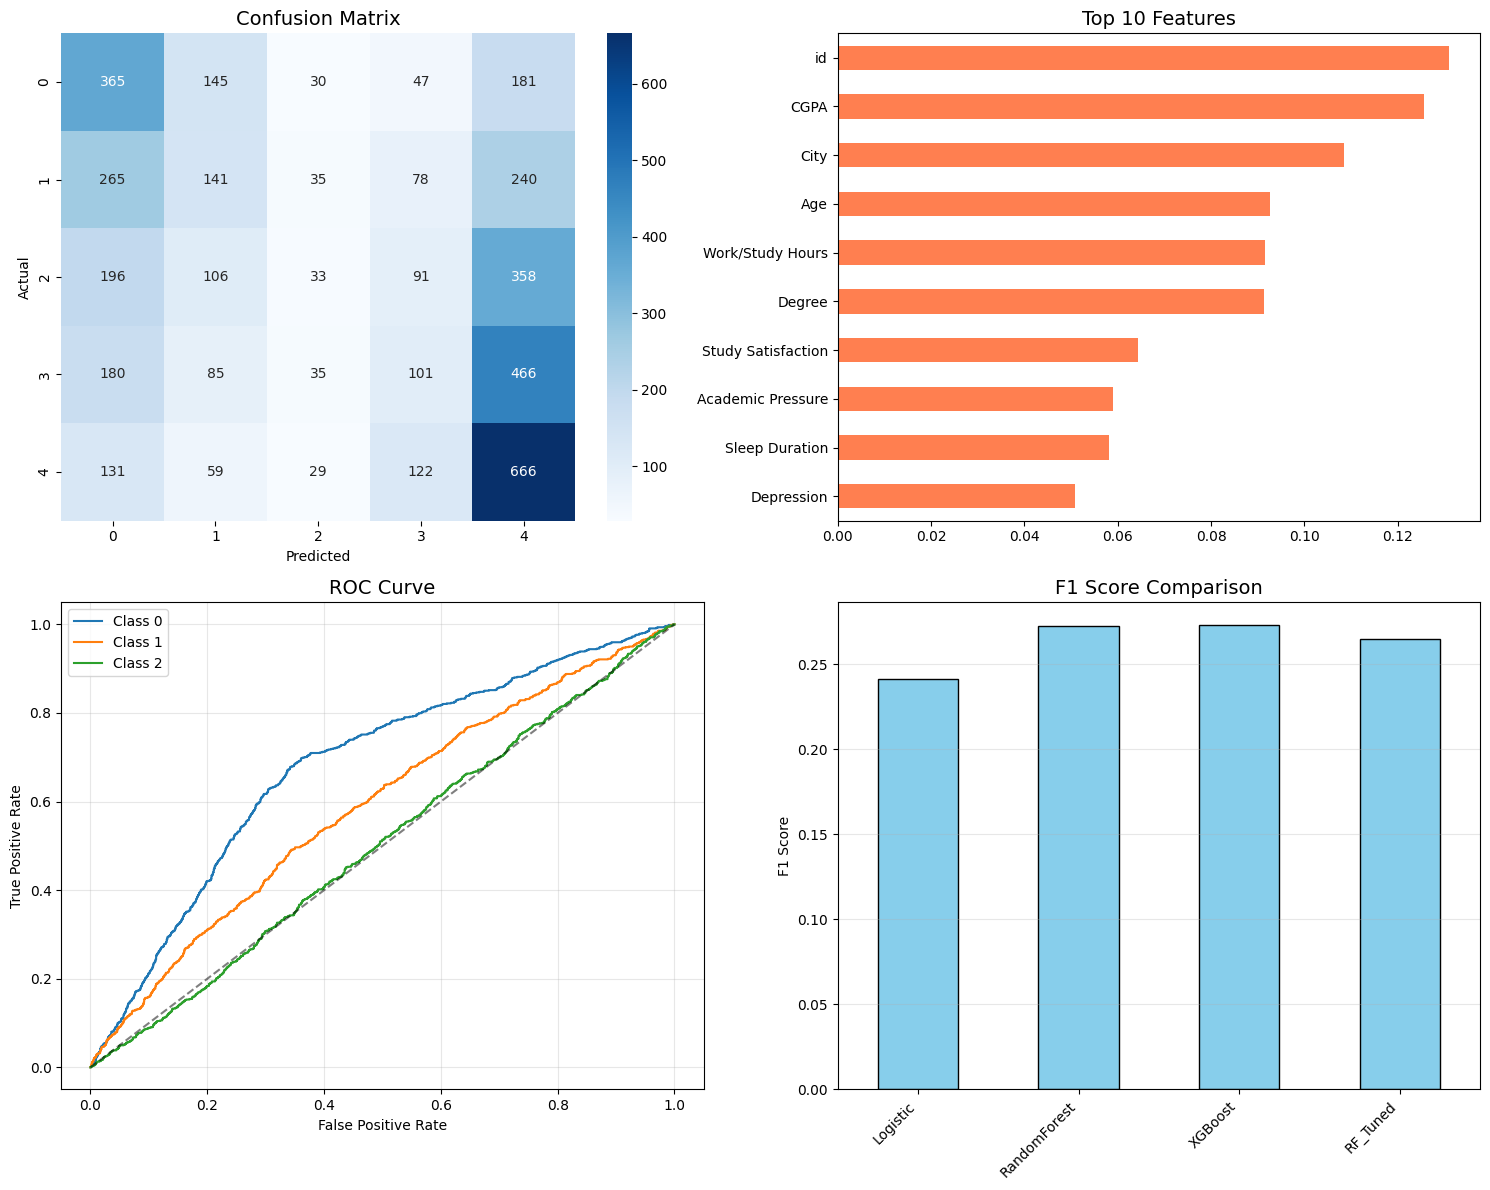

In [32]:
best_model = models['RF_Tuned']

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred, average='weighted')

    y_prob = model.predict_proba(X_test_scaled)
    if n_classes == 2:
        auc = roc_auc_score(y_test, y_prob[:, 1])
    else:
        y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
        auc = roc_auc_score(y_test_binarized, y_prob, multi_class='ovr', average='weighted')

    results[name] = {'F1': f1, 'AUC': auc}

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

cm = confusion_matrix(y_test, best_model.predict(X_test_scaled))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14)
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances.sort_values().tail(10).plot(kind='barh', ax=axes[0,1], color='coral')
axes[0,1].set_title('Top 10 Features', fontsize=14)

y_prob = best_model.predict_proba(X_test_scaled)
if n_classes == 2:
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
    axes[1,0].plot(fpr, tpr, linewidth=2, label=f'AUC={results["RF_Tuned"]["AUC"]:.3f}')
else:
    y_bin = label_binarize(y_test, classes=np.unique(y_test))
    for i in range(min(3, n_classes)):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob[:, i])
        axes[1,0].plot(fpr, tpr, label=f'Class {i}')

axes[1,0].plot([0,1], [0,1], 'k--', alpha=0.5)
axes[1,0].set_title('ROC Curve', fontsize=14)
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)


pd.DataFrame(results).T['F1'].plot(kind='bar', ax=axes[1,1], color='skyblue', edgecolor='black')
axes[1,1].set_title('F1 Score Comparison', fontsize=14)
axes[1,1].set_ylabel('F1 Score')
axes[1,1].set_xticklabels(results.keys(), rotation=45, ha='right')
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results.png', dpi=300, bbox_inches='tight')
plt.show()


In [33]:
print("\nTop 10 Important Features:")
print(importances.sort_values(ascending=False).head(10))



Top 10 Important Features:
id                    0.131075
CGPA                  0.125599
City                  0.108592
Age                   0.092725
Work/Study Hours      0.091604
Degree                0.091265
Study Satisfaction    0.064455
Academic Pressure     0.059093
Sleep Duration        0.058071
Depression            0.050801
dtype: float64


In [34]:
def predict_student(data):
    scaled = scaler.transform([data])
    pred = best_model.predict(scaled)[0]
    prob = best_model.predict_proba(scaled)[0]
    original_class = reverse_mapping[pred]
    return pred, original_class, prob

print("\nExample Predictions:")
mean = X.mean().values.tolist()

ex1 = mean.copy()
ex2 = mean.copy()

if len(mean) >= 3:
    ex1[0] *= 1.5
    ex2[0] *= 0.8

for i, data in enumerate([ex1, ex2], 1):
    pred, orig, prob = predict_student(data)
    print(f"Student {i}: Predicted={pred} (Original class={orig}), Confidence={prob.max():.1%}")



Example Predictions:
Student 1: Predicted=0 (Original class=1), Confidence=35.0%
Student 2: Predicted=0 (Original class=1), Confidence=31.5%
